<a href="https://colab.research.google.com/github/asdflazaro/Cow_Science_Robots/blob/main/Intervalo_de_captura.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Baixar e instalar o skopt
!pip install scikit-learn==1.0.0 -q -U
!pip install git+https://github.com/scikit-optimize/scikit-optimize.git -q -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.8/25.8 MB 36.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
# Imports
import numpy as np
import pandas as pd
import skopt

⏰ **Leitura dos dados - 1 segundo**

In [3]:
# Leitura e amostra da tabela
df = pd.read_csv('Tabela1s.csv', delimiter = ';')
df.head()

,Data,Hora,ax,ay,az,gx,gy,gz,Comportamento
0,27/01/2023,04:45:00,11669,5323,6348,1695,2941,-2270,1
1,27/01/2023,04:45:01,11130,7025,7761,-2178,-1819,2134,1
2,27/01/2023,04:45:02,10120,6610,10145,-2487,185,1868,1
3,27/01/2023,04:45:03,13629,3053,7777,-837,-4725,-3067,1
4,27/01/2023,04:45:04,13537,3296,7080,1245,-2580,571,1


In [4]:
# Exibe os tipos presentes na tabela
df.dtypes

Data             object
Hora             object
ax                int64
ay                int64
az                int64
gx                int64
gy                int64
gz                int64
Comportamento     int64
dtype: object

In [5]:
# Imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from skopt import gp_minimize

In [6]:
# Exibe as colunas existentes
df.columns

Index(['Data', 'Hora', 'ax', 'ay', 'az', 'gx', 'gy', 'gz', 'Comportamento'], dtype='object')

In [12]:
# Lista com os atributos aplicáveis - colunas
features_aplicaveis = ['ax', 'ay' ,'az', 'gx', 'gy', 'gz', 'Comportamento']

In [13]:
# Seleciona os abributos correspondentes da lista features_aplicaveis
df = df[features_aplicaveis]

In [14]:
def imprimir_quantidade_dados(X_train, X_test):
    print(10*"-"," Quantidade de dados ",  10*"-")
    
    print('Treino: ', X_train.shape[0])
    print('Teste: ', X_test.shape[0])
    
    print(43*"-")

In [15]:
y = df.Comportamento
X = df.drop('Comportamento', axis=1)

# Conjunto de dados PRO: Pastejando x Ruminando x Ócio
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state = 0, stratify=y)

In [16]:
imprimir_quantidade_dados(X_train, X_test)

----------  Quantidade de dados  ----------
Treino:  62896
Teste:  15725
-------------------------------------------


In [17]:
# Função para imprimir e salvar matriz de confusão
def imprimeMatrizDeConfusão(y_test, preds, model, salvarFigura = False):
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import ConfusionMatrixDisplay
    import matplotlib.pyplot as plt

    cm = confusion_matrix(y_test, preds, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(values_format= '.2%', xticks_rotation=60, colorbar=False)
    disp.ax_.set_title("Matriz de confusão normalizada sobre as condições verdadeiras")
    if(salvarFigura):
        plt.savefig(input('Nome da figura a ser salva:' ) + '.png')
    plt.show()

In [18]:
from sklearn.metrics import classification_report

def classification_report_extendido(y_true: np.array, y_pred: np.array, classes: set = None):
    report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    
    if classes is None: # Determina classes pelos valores
        classes = set(np.concatenate((np.unique(y_true), np.unique(y_pred))))
    for cls in classes:
        y_true_cls = (y_true == cls).astype(int)
        y_pred_cls = (y_pred == cls).astype(int)

        fp = sum(y_pred_cls[y_true_cls != 1])
        tn = sum(y_pred_cls[y_true_cls == 0] == False)
        fn = sum(y_pred_cls[y_true_cls == 1] == False)

        
        specificity_val = tn / (tn + fp)
        report[cls]['specificity'] = specificity_val
        npv_val = tn / (tn + fn)
        report[cls]['npv'] = npv_val
        
    return report

Predição

In [19]:
# imports
from sklearn.ensemble import RandomForestClassifier

In [20]:
rf_Model = RandomForestClassifier(random_state=0, n_jobs=-1)

In [21]:
# criação de um grid
rf_param_grid = {'n_estimators':  np.arange(50, 250, 50),
               'max_features': ['auto', 'sqrt'],
               'max_depth':[50, 100, 150, None],
               'criterion': ['gini', 'entropy'],
               'min_samples_split': [2, 5, 10, 30, 50],
               'min_samples_leaf': [1, 2],
               'bootstrap': [True, False]}

In [22]:
rf_RandomGrid = RandomizedSearchCV(estimator = rf_Model, param_distributions = rf_param_grid, cv = 3, verbose=1, random_state=0)

In [23]:
def tune_rf(params):
    n_estimators = params[0]
    max_features = params[1]
    max_depth = params[2]
    criterion = params[3]
    min_samples_split = params[4]
    min_samples_leaf = params[5]
    bootstrap = params[6]
    
    print(params, '\n')
    
    rf_Model = RandomForestClassifier(n_estimators=n_estimators, max_features=max_features, max_depth=max_depth, criterion=criterion, min_samples_split=min_samples_split,
                                       min_samples_leaf = min_samples_leaf, bootstrap=bootstrap, random_state=0, n_jobs=-1)
    
    auc = cross_val_score(rf_Model, X_train, y_train, cv=3, scoring ='accuracy')
    
    return -auc.mean()

space = [ np.arange(50, 250, 50), # n_estimators
         ['auto', 'sqrt'], # max_features
         [50, 100, 150, None], # max_depth
         ['gini', 'entropy'], # criterion
         [2, 5, 10, 30, 50], # min_samples_split
         [1,2,4], # min_samples_leaf
         [True, False]] # bootstrap] 

In [24]:
%%time
from skopt import forest_minimize
resultado_rf = gp_minimize(tune_rf, space, random_state=0, verbose=1, n_calls=30, n_random_starts=15, n_jobs=-1)

Iteration No: 1 started. Evaluating function at random point.
[150, 'sqrt', None, 'gini', 10, 2, False] 

Iteration No: 1 ended. Evaluation done at random point.
Time taken: 91.2557
Function value obtained: -0.9080
Current minimum: -0.9080
Iteration No: 2 started. Evaluating function at random point.
[50, 'auto', 100, 'gini', 10, 2, True] 

Iteration No: 2 ended. Evaluation done at random point.
Time taken: 18.0680
Function value obtained: -0.9072
Current minimum: -0.9080
Iteration No: 3 started. Evaluating function at random point.
[100, 'sqrt', 100, 'gini', 5, 4, False] 

Iteration No: 3 ended. Evaluation done at random point.
Time taken: 48.1109
Function value obtained: -0.9074
Current minimum: -0.9080
Iteration No: 4 started. Evaluating function at random point.
[150, 'sqrt', 150, 'gini', 10, 2, True] 

Iteration No: 4 ended. Evaluation done at random point.
Time taken: 63.6190
Function value obtained: -0.9076
Current minimum: -0.9080
Iteration No: 5 started. Evaluating function at

In [25]:
# Retorna o melhor hiperparametro
# Em ordem: n_estimators, max_features, max_depth, criterion, min_samples_split, min_samples_leaf, bootstrap
resultado_rf.x

[150, 'sqrt', None, 'gini', 10, 2, False]

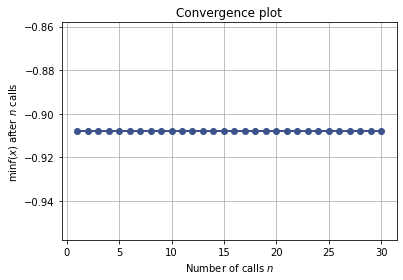

In [26]:
from skopt.plots import plot_convergence
plot_convergence(resultado_rf)

In [27]:
# Inserir manualmente os melhores hiperparametros
%%time
rf_model = RandomForestClassifier(n_estimators=150, max_features='sqrt', max_depth=None, criterion='gini',
                                  min_samples_split=10, min_samples_leaf=2 , bootstrap=False, random_state=0, n_jobs=-1)
rf_model.fit(X_train, y_train)
preds = rf_model.predict(X_test)

CPU times: user 58.6 s, sys: 43.9 ms, total: 58.6 s
Wall time: 35.1 s


In [28]:
# Retorna a acurácia
accuracy_score(y_test, preds)*100

91.17965023847377

In [29]:
# Retorna a tabela com alguns resultados
# digits= define quantidade de casas após a virgula
print(classification_report(y_test, preds, digits=4))

              precision    recall  f1-score   support

           1     0.8561    0.8785    0.8671      5152
           2     0.9400    0.9280    0.9340     10573

    accuracy                         0.9118     15725
   macro avg     0.8980    0.9033    0.9006     15725
weighted avg     0.9125    0.9118    0.9121     15725



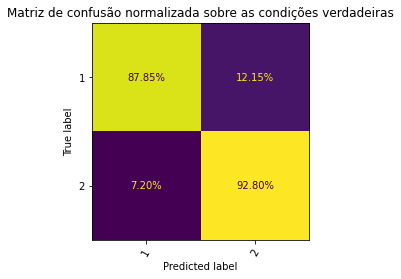

In [30]:
imprimeMatrizDeConfusão(y_test, preds, rf_model)

⏰ **Leitura dos dados - 2 segundo**

In [32]:
# Leitura e amostra da tabela
df = pd.read_csv('Tabela2s.csv', delimiter = ';')
df.head()

,Data,Hora,ax,ay,az,gx,gy,gz,Comportamento
0,27/01/2023,04:45:00,11669,5323,6348,1695,2941,-2270,1
1,27/01/2023,04:45:02,10120,6610,10145,-2487,185,1868,1
2,27/01/2023,04:45:04,13537,3296,7080,1245,-2580,571,1
3,27/01/2023,04:45:06,13314,1680,7984,-576,-272,155,1
4,27/01/2023,04:45:08,13757,647,6779,-318,1201,-472,1


In [33]:
# Exibe os tipos presentes na tabela
df.dtypes

Data             object
Hora             object
ax                int64
ay                int64
az                int64
gx                int64
gy                int64
gz                int64
Comportamento     int64
dtype: object

In [34]:
# Imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from skopt import gp_minimize

In [35]:
# Exibe as colunas existentes
df.columns

Index(['Data', 'Hora', 'ax', 'ay', 'az', 'gx', 'gy', 'gz', 'Comportamento'], dtype='object')

In [36]:
# Lista com os atributos aplicáveis - colunas
features_aplicaveis = ['ax', 'ay' ,'az', 'gx', 'gy', 'gz', 'Comportamento']

In [37]:
# Seleciona os abributos correspondentes da lista features_aplicaveis
df = df[features_aplicaveis]

In [38]:
def imprimir_quantidade_dados(X_train, X_test):
    print(10*"-"," Quantidade de dados ",  10*"-")
    
    print('Treino: ', X_train.shape[0])
    print('Teste: ', X_test.shape[0])
    
    print(43*"-")

In [39]:
y = df.Comportamento
X = df.drop('Comportamento', axis=1)

# Conjunto de dados PRO: Pastejando x Ruminando x Ócio
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state = 0, stratify=y)

In [40]:
imprimir_quantidade_dados(X_train, X_test)

----------  Quantidade de dados  ----------
Treino:  31436
Teste:  7860
-------------------------------------------


In [41]:
# Função para imprimir e salvar matriz de confusão
def imprimeMatrizDeConfusão(y_test, preds, model, salvarFigura = False):
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import ConfusionMatrixDisplay
    import matplotlib.pyplot as plt

    cm = confusion_matrix(y_test, preds, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(values_format= '.2%', xticks_rotation=60, colorbar=False)
    disp.ax_.set_title("Matriz de confusão normalizada sobre as condições verdadeiras")
    if(salvarFigura):
        plt.savefig(input('Nome da figura a ser salva:' ) + '.png')
    plt.show()

In [42]:
from sklearn.metrics import classification_report

def classification_report_extendido(y_true: np.array, y_pred: np.array, classes: set = None):
    report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    
    if classes is None: # Determina classes pelos valores
        classes = set(np.concatenate((np.unique(y_true), np.unique(y_pred))))
    for cls in classes:
        y_true_cls = (y_true == cls).astype(int)
        y_pred_cls = (y_pred == cls).astype(int)

        fp = sum(y_pred_cls[y_true_cls != 1])
        tn = sum(y_pred_cls[y_true_cls == 0] == False)
        fn = sum(y_pred_cls[y_true_cls == 1] == False)

        
        specificity_val = tn / (tn + fp)
        report[cls]['specificity'] = specificity_val
        npv_val = tn / (tn + fn)
        report[cls]['npv'] = npv_val
        
    return report

In [43]:
# imports
from sklearn.ensemble import RandomForestClassifier

In [44]:
rf_Model = RandomForestClassifier(random_state=0, n_jobs=-1)

In [45]:
# criação de um grid
rf_param_grid = {'n_estimators':  np.arange(50, 250, 50),
               'max_features': ['auto', 'sqrt'],
               'max_depth':[50, 100, 150, None],
               'criterion': ['gini', 'entropy'],
               'min_samples_split': [2, 5, 10, 30, 50],
               'min_samples_leaf': [1, 2],
               'bootstrap': [True, False]}

In [46]:
rf_RandomGrid = RandomizedSearchCV(estimator = rf_Model, param_distributions = rf_param_grid, cv = 3, verbose=1, random_state=0)

In [47]:
def tune_rf(params):
    n_estimators = params[0]
    max_features = params[1]
    max_depth = params[2]
    criterion = params[3]
    min_samples_split = params[4]
    min_samples_leaf = params[5]
    bootstrap = params[6]
    
    print(params, '\n')
    
    rf_Model = RandomForestClassifier(n_estimators=n_estimators, max_features=max_features, max_depth=max_depth, criterion=criterion, min_samples_split=min_samples_split,
                                       min_samples_leaf = min_samples_leaf, bootstrap=bootstrap, random_state=0, n_jobs=-1)
    
    auc = cross_val_score(rf_Model, X_train, y_train, cv=3, scoring ='accuracy')
    
    return -auc.mean()

space = [ np.arange(50, 250, 50), # n_estimators
         ['auto', 'sqrt'], # max_features
         [50, 100, 150, None], # max_depth
         ['gini', 'entropy'], # criterion
         [2, 5, 10, 30, 50], # min_samples_split
         [1,2,4], # min_samples_leaf
         [True, False]] # bootstrap] 

In [48]:
%%time
from skopt import forest_minimize
resultado_rf = gp_minimize(tune_rf, space, random_state=0, verbose=1, n_calls=30, n_random_starts=15, n_jobs=-1)

Iteration No: 1 started. Evaluating function at random point.
[150, 'sqrt', None, 'gini', 10, 2, False] 

Iteration No: 1 ended. Evaluation done at random point.
Time taken: 31.4201
Function value obtained: -0.9063
Current minimum: -0.9063
Iteration No: 2 started. Evaluating function at random point.
[50, 'auto', 100, 'gini', 10, 2, True] 

Iteration No: 2 ended. Evaluation done at random point.
Time taken: 6.7231
Function value obtained: -0.9056
Current minimum: -0.9063
Iteration No: 3 started. Evaluating function at random point.
[100, 'sqrt', 100, 'gini', 5, 4, False] 

Iteration No: 3 ended. Evaluation done at random point.
Time taken: 19.3941
Function value obtained: -0.9052
Current minimum: -0.9063
Iteration No: 4 started. Evaluating function at random point.
[150, 'sqrt', 150, 'gini', 10, 2, True] 

Iteration No: 4 ended. Evaluation done at random point.
Time taken: 19.3289
Function value obtained: -0.9061
Current minimum: -0.9063
Iteration No: 5 started. Evaluating function at 

In [49]:
# Retorna o melhor hiperparametro
# Em ordem: n_estimators, max_features, max_depth, criterion, min_samples_split, min_samples_leaf, bootstrap
resultado_rf.x

[150, 'sqrt', 50, 'gini', 10, 4, False]

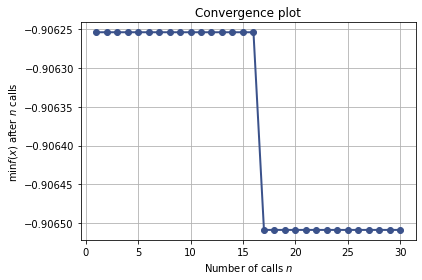

In [50]:
from skopt.plots import plot_convergence
plot_convergence(resultado_rf)

In [51]:
# Inserir manualmente os melhores hiperparametros
%%time
rf_model = RandomForestClassifier(n_estimators=150, max_features='sqrt', max_depth=50, criterion='gini',
                                  min_samples_split=10, min_samples_leaf=4 , bootstrap=False, random_state=0, n_jobs=-1)
rf_model.fit(X_train, y_train)
preds = rf_model.predict(X_test)

CPU times: user 24.8 s, sys: 27.3 ms, total: 24.8 s
Wall time: 14.6 s


In [52]:
# Retorna a acurácia
accuracy_score(y_test, preds)*100

91.23409669211196

In [53]:
# Retorna a tabela com alguns resultados
# digits= define quantidade de casas após a virgula
print(classification_report(y_test, preds, digits=4))

              precision    recall  f1-score   support

           1     0.8596    0.8753    0.8674      2574
           2     0.9387    0.9304    0.9345      5286

    accuracy                         0.9123      7860
   macro avg     0.8992    0.9028    0.9010      7860
weighted avg     0.9128    0.9123    0.9125      7860



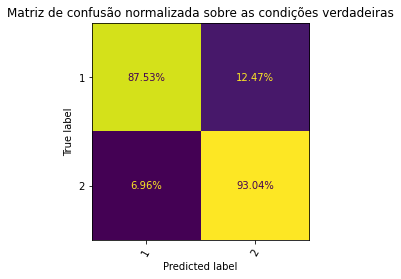

In [54]:
imprimeMatrizDeConfusão(y_test, preds, rf_model)

⏰ **Leitura dos dados - 5 segundo**

In [55]:
# Leitura e amostra da tabela
df = pd.read_csv('Tabela5s.csv', delimiter = ';')
df.head()

,Data,Hora,ax,ay,az,gx,gy,gz,Comportamento
0,27/01/2023,04:45:00,11669,5323,6348,1695,2941,-2270,1
1,27/01/2023,04:45:05,14396,37,7123,788,-115,2614,1
2,27/01/2023,04:45:10,15455,3777,5197,-3290,-4716,-2942,1
3,27/01/2023,04:45:20,11041,5976,6794,2375,5881,-1205,1
4,27/01/2023,04:45:25,12031,8183,8270,76,1433,485,1


In [56]:
# Exibe os tipos presentes na tabela
df.dtypes

Data             object
Hora             object
ax                int64
ay                int64
az                int64
gx                int64
gy                int64
gz                int64
Comportamento     int64
dtype: object

In [57]:
# Imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from skopt import gp_minimize

In [58]:
# Exibe as colunas existentes
df.columns

Index(['Data', 'Hora', 'ax', 'ay', 'az', 'gx', 'gy', 'gz', 'Comportamento'], dtype='object')

In [62]:
# Lista com os atributos aplicáveis - colunas
features_aplicaveis = ['ax', 'ay' ,'az', 'gx', 'gy', 'gz', 'Comportamento']

In [63]:
# Seleciona os abributos correspondentes da lista features_aplicaveis
df = df[features_aplicaveis]

In [64]:
def imprimir_quantidade_dados(X_train, X_test):
    print(10*"-"," Quantidade de dados ",  10*"-")
    
    print('Treino: ', X_train.shape[0])
    print('Teste: ', X_test.shape[0])
    
    print(43*"-")

In [65]:
y = df.Comportamento
X = df.drop('Comportamento', axis=1)

# Conjunto de dados PRO: Pastejando x Ruminando x Ócio
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state = 0, stratify=y)

In [66]:
imprimir_quantidade_dados(X_train, X_test)

----------  Quantidade de dados  ----------
Treino:  12601
Teste:  3151
-------------------------------------------


In [67]:
# Função para imprimir e salvar matriz de confusão
def imprimeMatrizDeConfusão(y_test, preds, model, salvarFigura = False):
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import ConfusionMatrixDisplay
    import matplotlib.pyplot as plt

    cm = confusion_matrix(y_test, preds, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(values_format= '.2%', xticks_rotation=60, colorbar=False)
    disp.ax_.set_title("Matriz de confusão normalizada sobre as condições verdadeiras")
    if(salvarFigura):
        plt.savefig(input('Nome da figura a ser salva:' ) + '.png')
    plt.show()

In [68]:
from sklearn.metrics import classification_report

def classification_report_extendido(y_true: np.array, y_pred: np.array, classes: set = None):
    report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    
    if classes is None: # Determina classes pelos valores
        classes = set(np.concatenate((np.unique(y_true), np.unique(y_pred))))
    for cls in classes:
        y_true_cls = (y_true == cls).astype(int)
        y_pred_cls = (y_pred == cls).astype(int)

        fp = sum(y_pred_cls[y_true_cls != 1])
        tn = sum(y_pred_cls[y_true_cls == 0] == False)
        fn = sum(y_pred_cls[y_true_cls == 1] == False)

        
        specificity_val = tn / (tn + fp)
        report[cls]['specificity'] = specificity_val
        npv_val = tn / (tn + fn)
        report[cls]['npv'] = npv_val
        
    return report

In [69]:
# imports
from sklearn.ensemble import RandomForestClassifier

In [70]:
rf_Model = RandomForestClassifier(random_state=0, n_jobs=-1)

In [71]:
# criação de um grid
rf_param_grid = {'n_estimators':  np.arange(50, 250, 50),
               'max_features': ['auto', 'sqrt'],
               'max_depth':[50, 100, 150, None],
               'criterion': ['gini', 'entropy'],
               'min_samples_split': [2, 5, 10, 30, 50],
               'min_samples_leaf': [1, 2],
               'bootstrap': [True, False]}

In [72]:
rf_RandomGrid = RandomizedSearchCV(estimator = rf_Model, param_distributions = rf_param_grid, cv = 3, verbose=1, random_state=0)

In [73]:
def tune_rf(params):
    n_estimators = params[0]
    max_features = params[1]
    max_depth = params[2]
    criterion = params[3]
    min_samples_split = params[4]
    min_samples_leaf = params[5]
    bootstrap = params[6]
    
    print(params, '\n')
    
    rf_Model = RandomForestClassifier(n_estimators=n_estimators, max_features=max_features, max_depth=max_depth, criterion=criterion, min_samples_split=min_samples_split,
                                       min_samples_leaf = min_samples_leaf, bootstrap=bootstrap, random_state=0, n_jobs=-1)
    
    auc = cross_val_score(rf_Model, X_train, y_train, cv=3, scoring ='accuracy')
    
    return -auc.mean()

space = [ np.arange(50, 250, 50), # n_estimators
         ['auto', 'sqrt'], # max_features
         [50, 100, 150, None], # max_depth
         ['gini', 'entropy'], # criterion
         [2, 5, 10, 30, 50], # min_samples_split
         [1,2,4], # min_samples_leaf
         [True, False]] # bootstrap] 

In [74]:
%%time
from skopt import forest_minimize
resultado_rf = gp_minimize(tune_rf, space, random_state=0, verbose=1, n_calls=30, n_random_starts=15, n_jobs=-1)

Iteration No: 1 started. Evaluating function at random point.
[150, 'sqrt', None, 'gini', 10, 2, False] 

Iteration No: 1 ended. Evaluation done at random point.
Time taken: 15.0422
Function value obtained: -0.9022
Current minimum: -0.9022
Iteration No: 2 started. Evaluating function at random point.
[50, 'auto', 100, 'gini', 10, 2, True] 

Iteration No: 2 ended. Evaluation done at random point.
Time taken: 2.1628
Function value obtained: -0.9019
Current minimum: -0.9022
Iteration No: 3 started. Evaluating function at random point.
[100, 'sqrt', 100, 'gini', 5, 4, False] 

Iteration No: 3 ended. Evaluation done at random point.
Time taken: 8.6421
Function value obtained: -0.9013
Current minimum: -0.9022
Iteration No: 4 started. Evaluating function at random point.
[150, 'sqrt', 150, 'gini', 10, 2, True] 

Iteration No: 4 ended. Evaluation done at random point.
Time taken: 7.4189
Function value obtained: -0.9026
Current minimum: -0.9026
Iteration No: 5 started. Evaluating function at ra

In [75]:
# Retorna o melhor hiperparametro
# Em ordem: n_estimators, max_features, max_depth, criterion, min_samples_split, min_samples_leaf, bootstrap
resultado_rf.x

[100, 'sqrt', 150, 'entropy', 2, 1, True]

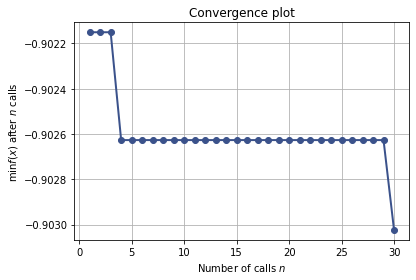

In [76]:
from skopt.plots import plot_convergence
plot_convergence(resultado_rf)

In [77]:
# Inserir manualmente os melhores hiperparametros
%%time
rf_model = RandomForestClassifier(n_estimators=100, max_features='sqrt', max_depth=150, criterion='entropy',
                                  min_samples_split=2, min_samples_leaf=1 , bootstrap=True, random_state=0, n_jobs=-1)
rf_model.fit(X_train, y_train)
preds = rf_model.predict(X_test)

CPU times: user 4.7 s, sys: 40.9 ms, total: 4.74 s
Wall time: 3.03 s


In [78]:
# Retorna a acurácia
accuracy_score(y_test, preds)*100

90.47921294827039

In [79]:
# Retorna a tabela com alguns resultados
# digits= define quantidade de casas após a virgula
print(classification_report(y_test, preds, digits=4))

              precision    recall  f1-score   support

           1     0.8403    0.8775    0.8585      1037
           2     0.9386    0.9182    0.9283      2114

    accuracy                         0.9048      3151
   macro avg     0.8894    0.8978    0.8934      3151
weighted avg     0.9062    0.9048    0.9053      3151



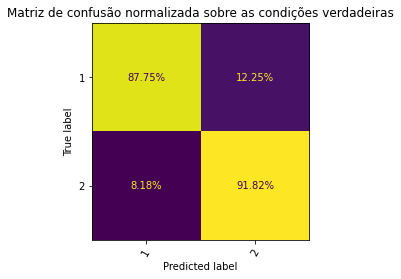

In [80]:
imprimeMatrizDeConfusão(y_test, preds, rf_model)

⏰ **Leitura dos dados - 10 segundos**

In [81]:
# Leitura e amostra da tabela
df = pd.read_csv('Tabela10s.csv', delimiter = ';')
df.head()

,Data,Hora,ax,ay,az,gx,gy,gz,Comportamento
0,27/01/2023,04:45:00,11669,5323,6348,1695,2941,-2270,1
1,27/01/2023,04:45:10,15455,3777,5197,-3290,-4716,-2942,1
2,27/01/2023,04:45:20,11041,5976,6794,2375,5881,-1205,1
3,27/01/2023,04:45:30,13125,-1943,7929,6067,4001,3819,1
4,27/01/2023,04:45:40,11195,8273,5761,292,-1201,-3766,1


In [82]:
# Exibe os tipos presentes na tabela
df.dtypes

Data             object
Hora             object
ax                int64
ay                int64
az                int64
gx                int64
gy                int64
gz                int64
Comportamento     int64
dtype: object

In [83]:
# Imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from skopt import gp_minimize

In [84]:
# Exibe as colunas existentes
df.columns

Index(['Data', 'Hora', 'ax', 'ay', 'az', 'gx', 'gy', 'gz', 'Comportamento'], dtype='object')

In [85]:
# Lista com os atributos aplicáveis - colunas
features_aplicaveis = ['ax', 'ay' ,'az', 'gx', 'gy', 'gz', 'Comportamento']

In [86]:
# Seleciona os abributos correspondentes da lista features_aplicaveis
df = df[features_aplicaveis]

In [87]:
def imprimir_quantidade_dados(X_train, X_test):
    print(10*"-"," Quantidade de dados ",  10*"-")
    
    print('Treino: ', X_train.shape[0])
    print('Teste: ', X_test.shape[0])
    
    print(43*"-")

In [88]:
y = df.Comportamento
X = df.drop('Comportamento', axis=1)

# Conjunto de dados PRO: Pastejando x Ruminando x Ócio
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state = 0, stratify=y)

In [89]:
imprimir_quantidade_dados(X_train, X_test)

----------  Quantidade de dados  ----------
Treino:  6306
Teste:  1577
-------------------------------------------


In [90]:
# Função para imprimir e salvar matriz de confusão
def imprimeMatrizDeConfusão(y_test, preds, model, salvarFigura = False):
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import ConfusionMatrixDisplay
    import matplotlib.pyplot as plt

    cm = confusion_matrix(y_test, preds, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(values_format= '.2%', xticks_rotation=60, colorbar=False)
    disp.ax_.set_title("Matriz de confusão normalizada sobre as condições verdadeiras")
    if(salvarFigura):
        plt.savefig(input('Nome da figura a ser salva:' ) + '.png')
    plt.show()

In [91]:
from sklearn.metrics import classification_report

def classification_report_extendido(y_true: np.array, y_pred: np.array, classes: set = None):
    report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    
    if classes is None: # Determina classes pelos valores
        classes = set(np.concatenate((np.unique(y_true), np.unique(y_pred))))
    for cls in classes:
        y_true_cls = (y_true == cls).astype(int)
        y_pred_cls = (y_pred == cls).astype(int)

        fp = sum(y_pred_cls[y_true_cls != 1])
        tn = sum(y_pred_cls[y_true_cls == 0] == False)
        fn = sum(y_pred_cls[y_true_cls == 1] == False)

        
        specificity_val = tn / (tn + fp)
        report[cls]['specificity'] = specificity_val
        npv_val = tn / (tn + fn)
        report[cls]['npv'] = npv_val
        
    return report

In [92]:
# imports
from sklearn.ensemble import RandomForestClassifier

In [93]:
rf_Model = RandomForestClassifier(random_state=0, n_jobs=-1)

In [94]:
# criação de um grid
rf_param_grid = {'n_estimators':  np.arange(50, 250, 50),
               'max_features': ['auto', 'sqrt'],
               'max_depth':[50, 100, 150, None],
               'criterion': ['gini', 'entropy'],
               'min_samples_split': [2, 5, 10, 30, 50],
               'min_samples_leaf': [1, 2],
               'bootstrap': [True, False]}

In [95]:
rf_RandomGrid = RandomizedSearchCV(estimator = rf_Model, param_distributions = rf_param_grid, cv = 3, verbose=1, random_state=0)

In [96]:
def tune_rf(params):
    n_estimators = params[0]
    max_features = params[1]
    max_depth = params[2]
    criterion = params[3]
    min_samples_split = params[4]
    min_samples_leaf = params[5]
    bootstrap = params[6]
    
    print(params, '\n')
    
    rf_Model = RandomForestClassifier(n_estimators=n_estimators, max_features=max_features, max_depth=max_depth, criterion=criterion, min_samples_split=min_samples_split,
                                       min_samples_leaf = min_samples_leaf, bootstrap=bootstrap, random_state=0, n_jobs=-1)
    
    auc = cross_val_score(rf_Model, X_train, y_train, cv=3, scoring ='accuracy')
    
    return -auc.mean()

space = [ np.arange(50, 250, 50), # n_estimators
         ['auto', 'sqrt'], # max_features
         [50, 100, 150, None], # max_depth
         ['gini', 'entropy'], # criterion
         [2, 5, 10, 30, 50], # min_samples_split
         [1,2,4], # min_samples_leaf
         [True, False]] # bootstrap] 

In [97]:
%%time
from skopt import forest_minimize
resultado_rf = gp_minimize(tune_rf, space, random_state=0, verbose=1, n_calls=30, n_random_starts=15, n_jobs=-1)

Iteration No: 1 started. Evaluating function at random point.
[150, 'sqrt', None, 'gini', 10, 2, False] 

Iteration No: 1 ended. Evaluation done at random point.
Time taken: 7.1835
Function value obtained: -0.8993
Current minimum: -0.8993
Iteration No: 2 started. Evaluating function at random point.
[50, 'auto', 100, 'gini', 10, 2, True] 

Iteration No: 2 ended. Evaluation done at random point.
Time taken: 1.6566
Function value obtained: -0.8984
Current minimum: -0.8993
Iteration No: 3 started. Evaluating function at random point.
[100, 'sqrt', 100, 'gini', 5, 4, False] 

Iteration No: 3 ended. Evaluation done at random point.
Time taken: 3.4122
Function value obtained: -0.8988
Current minimum: -0.8993
Iteration No: 4 started. Evaluating function at random point.
[150, 'sqrt', 150, 'gini', 10, 2, True] 

Iteration No: 4 ended. Evaluation done at random point.
Time taken: 4.3161
Function value obtained: -0.8984
Current minimum: -0.8993
Iteration No: 5 started. Evaluating function at ran

In [98]:
# Retorna o melhor hiperparametro
# Em ordem: n_estimators, max_features, max_depth, criterion, min_samples_split, min_samples_leaf, bootstrap
resultado_rf.x

[150, 'sqrt', 150, 'entropy', 10, 2, True]

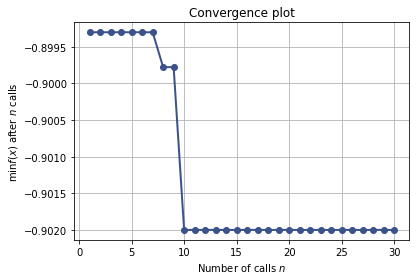

In [99]:
from skopt.plots import plot_convergence
plot_convergence(resultado_rf)

In [100]:
# Inserir manualmente os melhores hiperparametros
%%time
rf_model = RandomForestClassifier(n_estimators=150, max_features='sqrt', max_depth=150, criterion='entropy',
                                  min_samples_split=10, min_samples_leaf=2 , bootstrap=True, random_state=0, n_jobs=-1)
rf_model.fit(X_train, y_train)
preds = rf_model.predict(X_test)

CPU times: user 3.2 s, sys: 27.5 ms, total: 3.23 s
Wall time: 2.09 s


In [101]:
# Retorna a acurácia
accuracy_score(y_test, preds)*100

89.85415345592898

In [102]:
# Retorna a tabela com alguns resultados
# digits= define quantidade de casas após a virgula
print(classification_report(y_test, preds, digits=4))

              precision    recall  f1-score   support

           1     0.8499    0.8401    0.8450       519
           2     0.9220    0.9272    0.9246      1058

    accuracy                         0.8985      1577
   macro avg     0.8859    0.8836    0.8848      1577
weighted avg     0.8983    0.8985    0.8984      1577



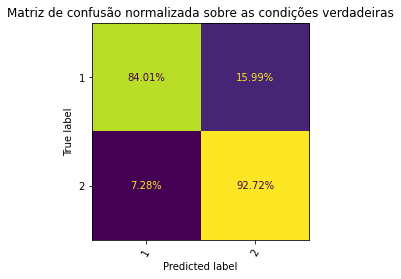

In [103]:
imprimeMatrizDeConfusão(y_test, preds, rf_model)